This notebook explores the relationship between rate distortion and privacy.

First, some preliminaries:

In [1]:
:set -XRebindableSyntax
:set -XNoImplicitPrelude

import Privacy.Prelude

We'll need some random variables:

In [2]:
import System.Random
import Statistics.Distribution.Normal
import System.Random.MWC
import Statistics.Distribution
import Graphics.Rendering.Chart.Plot.Histogram.Simple
import Control.Monad



We can build a huffman tree from these variables:

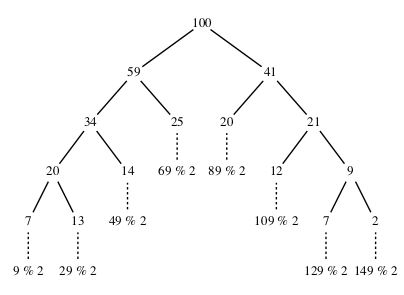

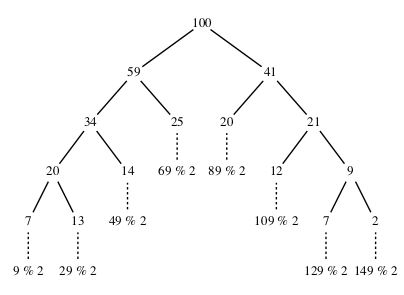

(0.0,0)
(0.0,1)
(0.94,2)
(47.076,3)
(57.081,4)
(311.0261111111111,5)
(325.4761111111111,6)
(369.4364957264957,7)
(369.4364957264957,8)
(437.74442873303167,9)
(437.74442873303167,10)
(456.8967014603044,11)
(456.8967014603044,13)
(519.7525237414715,14)
(519.7525237414715,16)
(540.6831487414715,17)
(541.1800690760389,18)
(541.1800690760389,29)
(572.5112904581757,30)
(572.5112904581757,39)
(595.1142,40)
(595.1142,100)

(0.0,0)
(0.0,1)
(1.3076666666666668,2)
(3.2968571428571427,3)
(5.094666666666667,4)
(5.844666666666667,5)
(9.911393939393939,6)
(16.09844522144522,7)
(17.471302364302364,8)
(17.471302364302364,10)
(40.15168331668332,11)
(43.742738095238096,12)
(65.28275641025641,13)
(65.28275641025641,24)
(126.40317307692308,25)
(126.40317307692308,26)
(211.36471153846153,27)
(211.36471153846153,48)
(595.1142,49)
(595.1142,100)

In [3]:
import Algebra.Information.Huffman
import Algebra.Information.Tree
import qualified Data.List.NonEmpty as NonEmpty
import Data.Functor.Contravariant
import Data.Bifunctor
import Data.Monoid
import qualified Data.Map.Strict as Map
import Algebra.Information.Huffman.Alphabetic

agesBot =
     [ ( 0, 7)
     , (10,13)
     , (20,14)
     , (30,25)
     , (40,20)
     , (50,12)
     , (60, 7)
     , (70, 2) ]

ages :: [(Rational, Int)]
ages = (fmap.first) (4.5+) agesBot
     
randAges :: IO [Rational]
randAges = (map toEnum  . concat) <$> traverse (\(x,y) -> replicateM y (getStdRandom (randomR (x,x+9)))) agesBot

:opt svg

tree
    = first getSum
    . huffmanTree defaultComparison (const (Sum 1)) 
    . NonEmpty.fromList 

agesTree = tree (ages >>= uncurry (flip replicate))
alphAgesTree = alphHuffman (Map.fromList ages)

alphAgesTree
optAlphHuffman ages


import Data.List (groupBy)
import Algebra.Information.Histogram
import Data.Function (on)
import Control.Arrow hiding (first)
import Control.Monad

kdistortion k = histogramDistortion . fmap Histogram . truncateTree (>=k) (flip Map.singleton)

bookend [] = []
bookend [x] = [x]
bookend [x,y] = [x,y]
bookend xs = [head xs, last xs]

kratedistortion tr
    = map ((`kdistortion` tr) &&& id)
  >>> groupBy ((==) `on` fst)
  >=> bookend
  >>> map (first (fromRational :: Rational -> Double))
  $ [0 .. measure tr]


rages <- randAges

ragesi = Map.fromListWith (+) . map (flip (,) 1) $ rages



mapM_ print (kratedistortion (tree rages))
mapM_ print (kratedistortion (alphHuffman ragesi))


For $k$-anonymity, we cut off revealing the tree at a certain point. Below that point, we simply return a summary of the subtree.

We can see what value of $k$ is provided after cutting off at a certain level by taking the minimum size of subtrees at that level:

In [8]:
randVar :: IO Rational
randVar = (toEnum.fromEnum) <$>
    withSystemRandom (genContVar (normalDistr 40 10) `asTypeOf`
                      const (undefined :: IO Double))
                      
randVars <- replicateM 3000 randVar

mapM_ print (kratedistortion (tree randVars))
mapM_ print (kratedistortion (alphHuffman (Map.fromListWith (+) . map (flip (,) 1) $ randVars)))

(0.0,0)
(0.0,1)
(1.0836666666666666,2)
(3.9978333333333333,3)
(7.581833333333333,4)
(11.547266666666667,5)
(11.547266666666667,6)
(15.965266666666666,7)
(16.525266666666667,8)
(24.043619607843137,9)
(24.043619607843137,10)
(24.38365294117647,11)
(24.38365294117647,12)
(26.23265294117647,13)
(26.236986274509803,14)
(26.236986274509803,15)
(30.72859917773561,16)
(30.72859917773561,17)
(32.83808937381404,18)
(43.42905253170878,19)
(43.42905253170878,22)
(43.43654882800507,23)
(43.43654882800507,24)
(50.80026882800507,25)
(50.80026882800507,26)
(50.80909901668432,27)
(50.80909901668432,28)
(53.71938441854326,29)
(53.71938441854326,32)
(53.73021518777403,33)
(53.73021518777403,34)
(60.64366728861437,35)
(60.64366728861437,37)
(63.625901908497404,38)
(63.625901908497404,42)
(63.92062783442333,43)
(63.92062783442333,46)
(75.45161730810754,47)
(75.45161730810754,50)
(85.09437456279399,51)
(85.09437456279399,54)
(85.11253970040868,55)
(85.11253970040868,59)
(85.44325847521374,60)
(85.4432584752

(0.0,0)
(0.0,1)
(5.722222222222222e-3,2)
(1.708888888888889e-2,3)
(2.894074074074074e-2,4)
(3.054074074074074e-2,5)
(6.52084656084656e-2,6)
(0.12112698412698412,7)
(0.12112698412698412,8)
(0.13761651713825626,9)
(0.13761651713825626,10)
(0.18206096158270071,11)
(0.18206096158270071,12)
(0.1867506167551145,13)
(0.19108395008844783,14)
(0.33997316966516744,15)
(0.33997316966516744,18)
(0.3559277151197129,19)
(0.3559277151197129,22)
(0.36472771511971286,23)
(0.5174214442167029,24)
(0.5174214442167029,26)
(0.5356893648018648,27)
(0.5448530011655012,28)
(0.5448530011655012,32)
(0.8780379680948567,33)
(0.8780379680948567,37)
(0.9108163607167276,38)
(0.9108163607167276,42)
(0.9258932837936505,43)
(0.9258932837936505,46)
(0.9424532837936506,47)
(0.9424532837936506,48)
(1.4331309561482648,49)
(1.4331309561482648,55)
(1.452561155578464,56)
(1.452561155578464,63)
(1.5378812219134559,64)
(1.5378812219134559,68)
(1.6426045208121154,69)
(1.6674445208121154,70)
(1.6674445208121154,76)
(2.413366435155

We can plot that $k$ against the number of bits revealed

In [5]:
import Graphics.Rendering.Chart.Plot.Lines
import Graphics.Rendering.Chart.Plot
import Graphics.Rendering.Chart.Layout
import Graphics.Rendering.Chart (toRenderable)
import Control.Lens ((.~))
import Data.Default


plotRateDistortion xs
    = toRenderable
    $ layout_plots .~ [ toPlot
                      $ PlotLines
                          "random vars"
                          defaultPlotLineStyle
                          [zip xs [0..]]
                          []
                      ]
    $ layout_x_axis.laxis_title .~ "k"
    $ layout_y_axis.laxis_title .~ "Level"
    $ def

plotRateDistortion (rates tree)

<interactive>:1:21: error:
    • Variable not in scope: rates :: ([()] -> Tree Integer ()) -> [x0]
    • Perhaps you meant ‘rages’ (line 1)

In [6]:
:ext FlexibleContexts

import           Control.Monad.State
import qualified Data.Map.Strict     as Map
import           Data.Foldable       (Foldable(..))
import           Algebra.Information.Huffman.Alphabetic (optAlphTree)
import           Data.Bifunctor (first)

buildAlphHuffman :: Histogram Count a -> Tree Count a
buildAlphHuffman xs = evalState (go c) (Map.toList (getHistogram xs))
  where
    c = fromEnum (sum (getCount <#$> getHistogram xs))
    go n = do
      (x,Count i) <- gets head
      if fromEnum i >= n
        then do
          modify tail
          pure (Leaf (Count i) x)
        else do
          let m = n `div` 2
          ls <- go m
          let nxt = n - fromEnum (getCount (measure ls))
          if nxt <= 0 then pure ls else do
            rs <- go nxt
            pure (Node (measure ls <> measure rs) ls rs)
            
buildOptAlphHuffman :: Ord a => Histogram Count a -> Tree Count a
buildOptAlphHuffman xs
    = first (Count . toEnum) 
    $ optAlphTree
    [ (fromEnum i, x)
    | (x,Count i) <- Map.toList (getHistogram xs) ]

alphHuffmanTree :: (Foldable1 f, Ord a) => f a -> Tree Count a
alphHuffmanTree = buildAlphHuffman . generalizeTo (histogramOf count)

<interactive>:1:58: error: Module ‘Algebra.Information.Huffman.Alphabetic’ does not export ‘optAlphTree’